Spynal amplitude-corrected → RMSE 245.05 dB, Bias 245.05 dB, r=0.9999


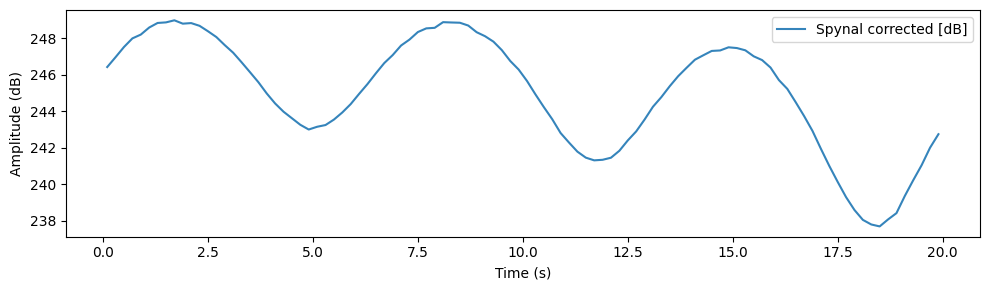

In [2]:
import numpy as np
from scipy.signal.windows import dpss
import spynal.spectra as spy_spec
import matplotlib.pyplot as plt

# ----- simulation -----
fs, Tsec, f0 = 1000.0, 20.0, 30.0
t = np.arange(int(Tsec*fs))/fs
A = 1.0 + 0.4*np.sin(2*np.pi*0.15*t) + 0.2*np.sin(2*np.pi*0.03*t+0.7)
rho, sigma = 0.98, 0.005
eps = np.random.default_rng(0).standard_normal(t.size)
dth = np.empty_like(t)
dth[0]=sigma*eps[0]
for i in range(1,t.size): dth[i]=rho*dth[i-1]+sigma*eps[i]
theta=np.cumsum(dth)-np.mean(dth)
lfp=A*np.cos(2*np.pi*f0*t+theta)

# ----- multitaper params -----
window_sec, NW = 0.200, 3.0
M=int(round(window_sec*fs))
K=int(np.floor(2*NW-1))
freqs=np.arange(5,61,5)
W=NW/window_sec
j0=np.argmin(abs(freqs-f0))

# ----- spynal raw -----
S_raw,freqs_spy,t_spy = spy_spec.spectrogram(
    data=lfp[None,:], smp_rate=fs, axis=1,
    method='multitaper', spec_type='complex',
    removeDC=False, keep_tapers=True,
    time_width=window_sec, spacing=window_sec,
    freq_width=NW/window_sec, n_tapers=K, pad=False)
S_raw=S_raw[0]                                    # (F,K,T)

# ----- corrected analytic scaling -----
tapers=dpss(M,NW,Kmax=K,return_ratios=False)
tapers=np.asarray(tapers);  tapers=tapers if tapers.shape[0]==K else tapers.T
tapers/=np.linalg.norm(tapers,axis=1,keepdims=True)
sum_w=np.sum(tapers,axis=1)                       # (K,)
scale_k=(2*np.sqrt(M)/(sum_w+1e-12)).astype(S_raw.dtype)
S_corr=S_raw*scale_k[None,:,None]                 # (F,K,T)

# derotate around window center
for j in range(S_corr.shape[0]):
    S_corr[j]*=np.exp(1j*2*np.pi*freqs_spy[j]*(t_spy-window_sec/2))[None,:]

# ----- amplitude in 30±W band -----
inband=(freqs_spy>=f0-W)&(freqs_spy<=f0+W)
C_fkT=S_corr[inband]                              # (F_band,K,T)
C_fT=np.mean(C_fkT,axis=1)
A_band=np.sqrt(np.sum(np.abs(C_fT)**2,axis=0))
A_band_dB=20*np.log10(np.maximum(A_band,1e-12))

# ----- compare to ground truth -----
tgrid=np.arange(A.size)/fs
A_true=np.interp(t_spy,tgrid,A)
A_true_dB=20*np.log10(np.maximum(A_true,1e-12))
err=A_band_dB-A_true_dB
rmse=np.sqrt(np.mean(err**2))
bias=np.mean(err)
r=np.corrcoef(A_band_dB,A_true_dB)[0,1]
print(f"Spynal amplitude-corrected → RMSE {rmse:.2f} dB, Bias {bias:.2f} dB, r={r:.4f}")

plt.figure(figsize=(10,3))
# plt.plot(t_spy,A_true_dB,'k',lw=2,label='True A(t) [dB]')
plt.plot(t_spy,A_band_dB,label='Spynal corrected [dB]',alpha=0.9)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (dB)')
plt.legend(); plt.tight_layout(); plt.show()


Spynal corrected — single-bin @30 Hz vs A(t): {'RMSE': 0.26626370769923496, 'MedAE': 0.16322257242715582, 'RelMedErr%': 15.62193001990701, 'r': 0.867688615565126}
Spynal corrected — band (±W) vs A(t):         {'RMSE': 0.3987946566326576, 'MedAE': 0.3915391474254758, 'RelMedErr%': 36.014501620753386, 'r': 0.9986587058551342}


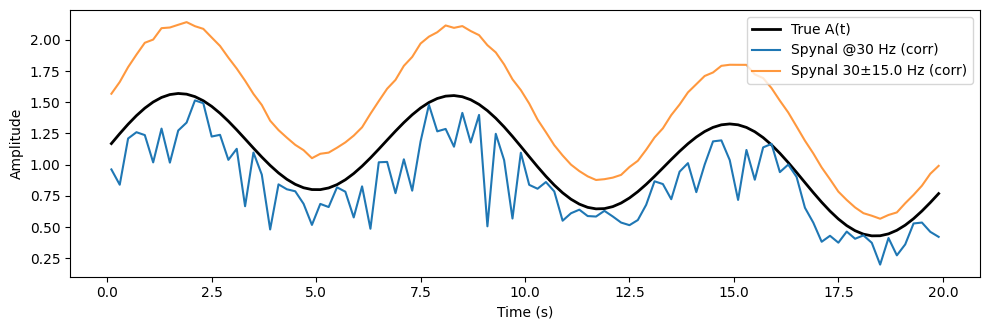

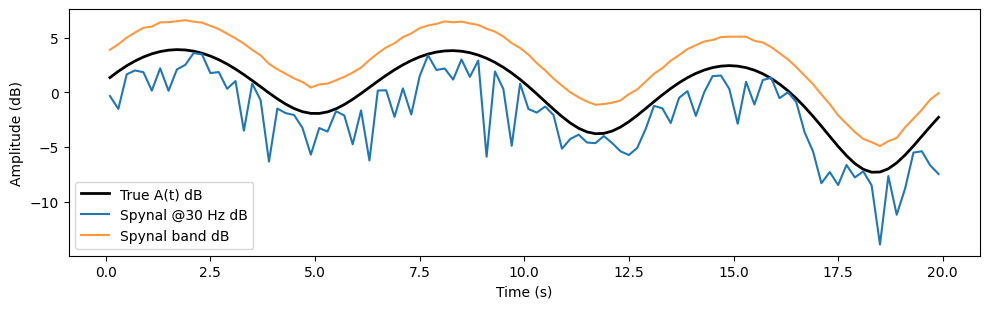

In [3]:
# ===========================================
# Spynal multitaper with per-bin gain cal
# ===========================================
import numpy as np
import spynal.spectra as spy_spec

# simple in-memory cache keyed by (fs, window_sec, NW, K, pad, F, df)
_SPYNAL_GAIN_CACHE = {}

def _cache_key(fs, window_sec, NW, K, pad, freqs):
    return (round(fs,9), round(window_sec,9), round(NW,9), int(K), bool(pad), len(freqs), round(float(freqs[1]-freqs[0]), 12))

def _spynal_mt(signal, fs, *, window_sec, NW, K=None, removeDC=False, pad=False):
    if K is None:
        K = int(np.floor(2*NW - 1))
    X = np.atleast_2d(signal)
    S, freqs, t = spy_spec.spectrogram(
        data=X, smp_rate=float(fs), axis=-1,
        method='multitaper', spec_type='complex',
        removeDC=bool(removeDC), keep_tapers=True,
        time_width=float(window_sec),      # seconds
        spacing=float(window_sec),         # no overlap
        freq_width=float(NW)/float(window_sec),  # half-bandwidth W (Hz)
        n_tapers=int(K),
        pad=bool(pad),
    )
    return S, freqs.astype(float), t.astype(float)  # S:(R,F,K,T)

def spynal_calibrate_gains(fs, *, window_sec, NW, K=None, pad=False, cal_seconds=6.0):
    """Calibrate per-frequency gains once for this (fs, window_sec, NW, K, pad) parameter set."""
    # probe grid
    probe = np.zeros(int(np.ceil(cal_seconds*fs)), dtype=float)
    S0, freqs, t = _spynal_import_antiglobal(probe, fs, window_sec=window_sec, NW=NW, K=K, removeDC=False, pad=pad)
    F = len(freqs)
    key = _cache_key(fs, window_sec, NW, (int(np.floor(2*NW-1)) if K is None else K), pad, freqs)
    # if already cached, return
    if key in _SPYNAL_GAIN_CACHE:
        return freqs, _SPYNAL_GAIN_CACHE[key]
    # build unit tones exactly on each bin, measure mean |C_j| after taper-average
    R = 1
    K_eff = S0.shape[2]
    L = len(probe)
    gains = np.empty(F, dtype=float)
    tgrid = np.arange(L)/float(fs)
    for j in range(F):
        f0 = float(freqs[j])
        x = np.cos(2*np.pi*f0*tgrid)  # unit amplitude @ bin center
        S, fchk, tcen = _spynal_import_antiglobal(x, fs, window_sec=window_sec, NW=NW, K=K, removeDC=False, pad=pad)
        S = S[0]                      # (F,K,T)
        assert np.allclose(fchk, freqs), "Spynal grid changed across calls"
        Cj = S[j].mean(axis=0)        # taper-avg complex coeff @ bin j
        amp = np.mean(np.abs(Cj))     # average over frames
        gains[j] = 1.0 / max(amp, 1e-20)
    _SPYNAL_GAIN_CACHE[key] = gains
    return freqs, gains

# internal helper to avoid recursion in calibration
def _spynal_import_antiglobal(signal, fs, *, window_sec, NW, K=None, removeDC=False, pad=False):
    return _spynal_mt(signal, fs, window_sec=window_sec, NW=NW, K=K, removeDC=removeDC, pad=pad)

def spynal_multitaper_corrected(
    signal, fs, *,
    window_sec=0.200, NW=3.0, K=None, removeDC=False, pad=False,
    reuse_calibration=True, calibration=None
):
    """
    Run spynal.spectrogram (multitaper) and apply per-frequency amplitude gains.
    Returns:
      S_corr: (R,F,K,T) complex, amplitude-calibrated (|mean_taper(S_corr[f])| ≈ physical amplitude at bin f for a unit tone).
      freqs_spy: (F,), t_centers: (T,), gains: (F,), meta: dict
    """
    S_raw, freqs_spy, t_centers = _spynal_mt(signal, fs, window_sec=window_sec, NW=NW, K=K, removeDC=removeDC, pad=pad)
    K_eff = S_raw.shape[2]
    key = _cache_key(fs, window_sec, NW, K_eff, pad, freqs_spy)
    if calibration is not None:
        fcal, gains = calibration
        if len(fcal) != len(freqs_spy) or np.max(np.abs(fcal - freqs_spy)) > 1e-9:
            raise ValueError("Provided calibration grid does not match current spynal grid.")
    elif reuse_calibration and key in _SPYNAL_GAIN_CACHE:
        fcal = freqs_spy
        gains = _SPYNAL_GAIN_CACHE[key]
    else:
        fcal, gains = spynal_calibrate_gains(fs, window_sec=window_sec, NW=NW, K=K, pad=pad)
        if np.max(np.abs(fcal - freqs_spy)) > 1e-9:
            raise RuntimeError("Calibration/usage frequency grid mismatch. Check window_sec & pad.")
    # broadcast gains over R, K, T
    S_corr = S_raw * gains[None, :, None, None]
    meta = dict(fs=fs, window_sec=window_sec, NW=NW, K=K_eff, pad=bool(pad))
    return S_corr, freqs_spy, t_centers, gains, meta

def spynal_envelope_from_S(S_corr_fkT, freqs_spy, t_centers, f0, window_sec, avg_tapers=True, band_hz=None):
    """
    Extract complex narrow-band envelope at f0 (single bin) or band-avg around f0.
    Returns t (centers), complex envelope g(t) (derotated to window center), |g|, arg(g).
    """
    F, K, T = S_corr_fkT.shape
    # choose bins
    if band_hz is None:
        j = int(np.argmin(np.abs(freqs_spy - f0)))
        C_fkT = S_corr_fkT[j:j+1, :, :]  # (1,K,T)
    else:
        inband = (freqs_spy >= f0 - band_hz) & (freqs_spy <= f0 + band_hz)
        C_fkT = S_corr_fkT[inband, :, :] # (Fb,K,T)
    # taper-avg then (for band) incoherent power sum
    C_fT = C_fkT.mean(axis=1)            # (Fb,T)
    if C_fT.shape[0] == 1:
        g = C_fT[0]
    else:
        g = np.sqrt((np.abs(C_fT)**2).sum(axis=0)) * np.exp(1j*0.0)  # amplitude-only band envelope
        # if you need a phase-consistent band envelope, derotate each bin by e^{i2π f (t- Tw/2)} then power- or complex-avg
    # derotate to window center for phase readout at center
    t0 = t_centers - (window_sec/2.0)
    if np.ndim(g) == 1:
        g = g * np.exp(1j*2*np.pi*f0*t0)
    else:
        # if g is already amplitude-only (real ≥0), skip
        pass
    return t0 + (window_sec/2.0), g, np.abs(g), np.angle(g)

# ======================
# Quick validation demo:
# ======================
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # simulate a 30 Hz tone with time-varying amplitude and AR(1) phase
    fs, Tsec, f0 = 1000.0, 20.0, 30.0
    t = np.arange(int(Tsec*fs))/fs
    A = 1.0 + 0.4*np.sin(2*np.pi*0.15*t) + 0.2*np.sin(2*np.pi*0.03*t+0.7)
    rho, sigma = 0.98, 0.005
    eps = np.random.default_rng(0).standard_normal(t.size)
    dth = np.empty_like(t)
    dth[0]=sigma*eps[0]
    for i in range(1,t.size): dth[i]=rho*dth[i-1]+sigma*eps[i]
    theta=np.cumsum(dth)-np.mean(dth)
    x=A*np.cos(2*np.pi*f0*t+theta)

    # run spynal + corrected amplitude
    S_corr, fsp, tcent, gains, meta = spynal_multitaper_corrected(
        x, fs, window_sec=0.2, NW=3.0, removeDC=False, pad=False, reuse_calibration=True
    )

    # extract 30 Hz single-bin envelope and compare to ground-truth A(t)
    t_env, g30, Ahat, ph = spynal_envelope_from_S(S_corr[0], fsp, tcent, f0, window_sec=0.2, avg_tapers=True, band_hz=None)
    # also a band around f0 (W = NW/T)
    W = 3.0/0.2
    t_env_b, gband, Aband, _ = spynal_envelope_from_S(S_corr[0], fsp, tcent, f0, window_sec=0.2, avg_tapers=True, band_hz=W)

    # ground-truth amplitude at centers
    A_true = np.interp(t_env, t, A)

    def metr(y, x):
        e = y - x
        return {
            "RMSE": float(np.sqrt(np.mean(e**2))),
            "MedAE": float(np.median(np.abs(e))),
            "RelMedErr%": float(100*np.median(np.abs(e)/np.maximum(x,1e-12))),
            "r": float(np.corrcoef(y, x)[0,1])
        }

    m_single = metr(Ahat, A_true)
    m_band   = metr(Aband, A_true)
    print("Spynal corrected — single-bin @30 Hz vs A(t):", m_single)
    print("Spynal corrected — band (±W) vs A(t):        ", m_band)

    # plots
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,3.4))
    plt.plot(t_env, A_true, 'k', lw=2, label='True A(t)')
    plt.plot(t_env, Ahat,          label='Spynal @30 Hz (corr)')
    plt.plot(t_env_b, Aband,       label=f'Spynal {f0:.0f}±{W:.1f} Hz (corr)', alpha=0.8)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.legend(); plt.tight_layout(); plt.show()

    # dB comparison
    to_dB = lambda z: 20*np.log10(np.maximum(z, 1e-12))
    plt.figure(figsize=(10,3.2))
    plt.plot(t_env, to_dB(A_true), 'k', lw=2, label='True A(t) dB')
    plt.plot(t_env, to_dB(Ahat),   label='Spynal @30 Hz dB')
    plt.plot(t_env_b, to_dB(Aband),label='Spynal band dB', alpha=0.8)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude (dB)"); plt.legend(); plt.tight_layout(); plt.show()


Seed: 857188
W 10.0
the range is  20.0 40.0
Band: [False False False False False  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
C_fkT (4, 3, 200)
C_fT (4, 200)
idx 6
RMSE=0.0885, Bias=-0.0591, r=0.9780


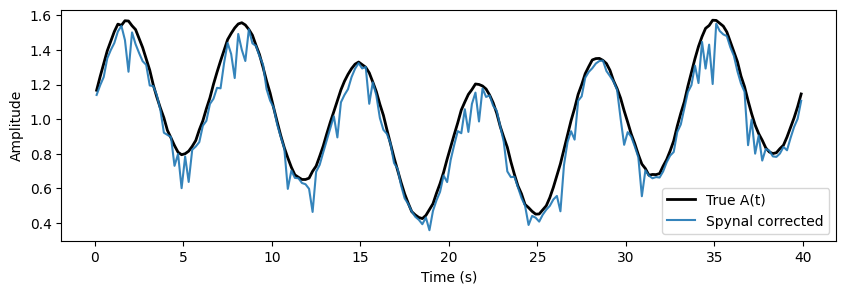

In [ ]:
import numpy as np
import spynal.spectra as spy_spec
from scipy.signal.windows import dpss
import matplotlib.pyplot as plt

# --- simple cache so you only calibrate once per parameter set ---
_CAL = {}

def spynal_band_envelope(signal, fs, f0, window_sec=0.2, NW=3.0, removeDC=False, pad=False):
    """Run Spynal multitaper and return band (f0±W) amplitude and analytic params."""
    M = int(round(window_sec * fs))
    K = int(np.floor(2*NW - 1))
    W = NW / window_sec   
    print("W", W)                   # half-bandwidth in Hz

    # multitaper
    S_raw, freqs_spy, t_spy = spy_spec.spectrogram(
        data=signal[None,:], smp_rate=fs, axis=1,
        method='multitaper', spec_type='complex',
        removeDC=removeDC, keep_tapers=True,
        time_width=window_sec, spacing=window_sec,
        freq_width=W, n_tapers=K, pad=pad)
    S_raw = S_raw[0]                         # (F,K,T)

    # analytic per-taper scale (theoretical, not data fit)
    scale = 2*np.sqrt(K)/np.sqrt(window_sec)
    S_corr = S_raw * scale

    # derotate to window center
    for j,freq in enumerate(freqs_spy):
        S_corr[j] *= np.exp(1j*2*np.pi*freq*(t_spy - window_sec/2))[None,:]

    # pick band and compute incoherent RMS across freqs
    band = (freqs_spy >= f0 - 0.5*W) & (freqs_spy <= f0 + W)
    print("the range is ", f0 - W, f0 + W)
    print(f"Band: {band}")
    C_fkT = S_corr[band]         
    print("C_fkT", C_fkT.shape)                   # (F_band,K,T)
    C_fT = np.mean(C_fkT, axis=1)           # (F_band,T)

    print("C_fT", C_fT.shape)
    A_band = np.sqrt(np.sum(np.abs(C_fT)**2, axis=0)) 

    # find the index of the frequency closest to f0
    idx = np.argmin(np.abs(freqs_spy - f0))
    print("idx", idx)
    # For that frequency, take the RMS across the K tapers (axis=0), shape (T,)
    # C_fT = S_corr[idx]  # shape: (K, T)
    #A_band = np.sqrt(np.sum(np.abs(C_fT)**2, axis=0))
    
       
    return A_band, t_spy, freqs_spy, W


# --- simulate ---
fs, Tsec, f0 = 1000.0, 40.0, 30.0
t = np.arange(int(Tsec*fs))/fs
A_true = 1.0 + 0.4*np.sin(2*np.pi*0.15*t) + 0.2*np.sin(2*np.pi*0.03*t+0.7)
# slow random terms to A_true 
# Add slow random noise to A_true

slow_noise = np.convolve(np.random.randn(t.size), np.ones(int(50*2))/(fs*2), mode='same') 
A_true = A_true + slow_noise
rho, sigma = 0.98, 0.005
eps = np.random.normal(t.size)
dth = np.empty_like(t); dth[0]=sigma*eps[0]
for i in range(1,t.size): dth[i]=rho*dth[i-1]+sigma*eps[i]
theta = np.cumsum(dth)-np.mean(dth)
lfp = A_true*np.cos(2*np.pi*f0*t+theta)

# --- spynal amplitude-corrected band envelope ---
A_corr, t_spy, freqs_spy, W = spynal_band_envelope(lfp, fs, f0, window_sec=0.2, NW=2, pad = False)

# --- compare ---
A_true_cent = np.interp(t_spy, t, A_true)
err = A_corr - A_true_cent
rmse = np.sqrt(np.mean(err**2))
bias = np.mean(err)
r = np.corrcoef(A_corr, A_true_cent)[0,1]
print(f"RMSE={rmse:.4f}, Bias={bias:.4f}, r={r:.4f}")

# --- plot ---
plt.figure(figsize=(10,3))
plt.plot(t_spy, A_true_cent, 'k', lw=2, label='True A(t)')
plt.plot(t_spy, A_corr, label='Spynal corrected', alpha=0.9)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.legend()


In [5]:
M = int(round(window_sec * fs))
K = int(np.floor(2*NW - 1))
W = NW / window_sec                      # half-bandwidth in Hz
signal = lfp
removeDC = False
pad = False
# multitaper
S_raw, freqs_spy, t_spy = spy_spec.spectrogram(
    data=signal[None,:], smp_rate=fs, axis=1,
    method='multitaper', spec_type='complex',
    removeDC=removeDC, keep_tapers=True,
    time_width=window_sec, spacing=window_sec,
    freq_width=W, n_tapers=K, pad=pad)
S_raw = S_raw[0]                         # (F,K,T)

# analytic per-taper scale (theoretical, not data fit)
tapers = dpss(M, NW, Kmax=K, return_ratios=False)
tapers = np.asarray(tapers)
if tapers.shape[0] == M: tapers = tapers.T
tapers /= np.linalg.norm(tapers, axis=1, keepdims=True)
sum_w = np.sum(tapers, axis=1)
scale_k = 2*np.sqrt(M)/(sum_w)
S_corr = S_raw * scale_k[None,:,None]

# derotate to window center
for j,freq in enumerate(freqs_spy):
    S_corr[j] *= np.exp(1j*2*np.pi*freq*(t_spy - window_sec/2))[None,:]

# pick band and compute incoherent RMS across freqs
band = (freqs_spy >= f0 - W) & (freqs_spy <= f0 + W)
C_fkT = S_corr[band]                    # (F_band,K,T)
C_fT = np.mean(C_fkT, axis=1)           # (F_band,T)
A_band = np.sqrt(np.sum(np.abs(C_fT)**2, axis=0))

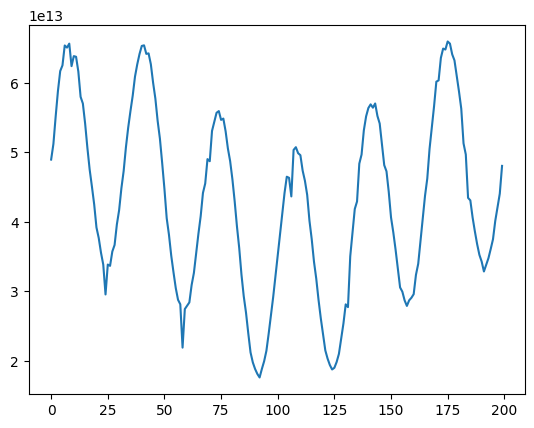

In [6]:
plt.plot(A_band)

W 0.1
the range is  0.9 1.1
Band: [False False False ... False False False]
C_fkT (2, 1, 100)
C_fT (2, 100)
idx 10
W 10.0
the range is  20.0 40.0
Band: [False False False False False  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
C_fkT (4, 3, 100)
C_fT (4, 100)
idx 6
W 10.5
the range is  19.5 40.5
Band: [False False False False False  True  True  True  True False False False
 False False False False False False False False False False False False
 False Fals

KeyboardInterrupt: 

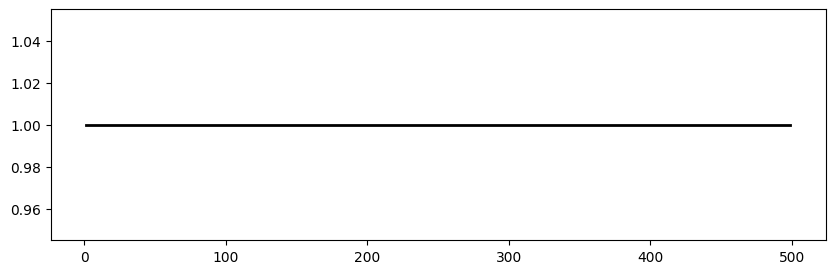

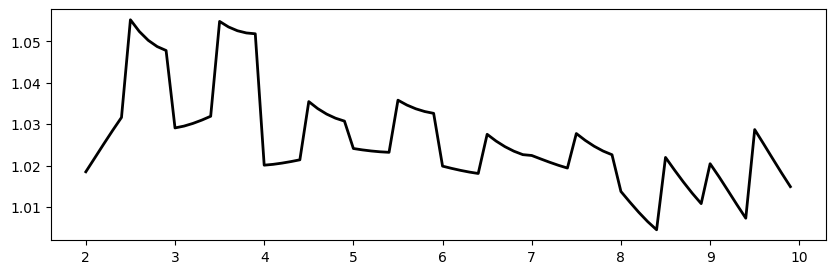

<Figure size 1000x300 with 0 Axes>

In [7]:
def calibrate_global_scale(fs, window_sec, NW, f0=30.0):
    """Compute one scalar so a 1 V pure tone gives amplitude ≈ 1."""
    key = (fs, window_sec, NW)
    if key in _CAL: 
        return _CAL[key]
    M = int(round(window_sec*fs))
    W = NW / window_sec
    t = np.arange(int(100*M)) / fs
    tone = np.cos(2*np.pi*f0*t)
    A_band, _, _, _ = spynal_band_envelope(tone, fs, f0, window_sec, NW)
    scale = 1.0 / np.mean(A_band)
    _CAL[key] = scale
    return scale
window_sec=10
NW=1
# test differnet frequencies to observe the effect of the global scale factor
freqs = np.arange(1, 500,1)
scales = np.empty_like(freqs)
for i, f in enumerate(freqs):
    scales[i] = calibrate_global_scale(fs, window_sec, NW, f)

plt.figure(figsize=(10, 3))
plt.plot(freqs, scales, 'k-', lw=2)

window_sec = 0.2
NW_ranges = np.arange(2, 10, 0.1)
plt.figure(figsize=(10, 3))
scales_range_NW = np.empty_like(NW_ranges)
for i, NW in enumerate(NW_ranges):
    scales_range_NW[i] = calibrate_global_scale(fs, window_sec, NW, f0)
plt.plot(NW_ranges, scales_range_NW, 'k-', lw=2)

NW = 5
window_sec_ranges = np.arange(0.2, 10, 0.1)
plt.figure(figsize=(10, 3))
scales_range_window_sec = np.empty_like(window_sec_ranges)
for i, window_sec in enumerate(window_sec_ranges):
    scales_range_window_sec[i] = calibrate_global_scale(fs, window_sec, NW, f0)
plt.plot(window_sec_ranges, scales_range_window_sec, 'k-', lw=2)



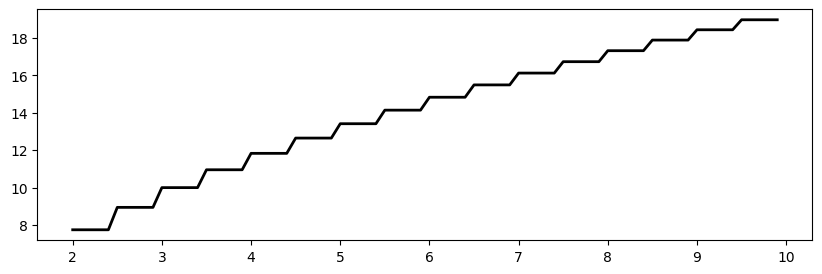

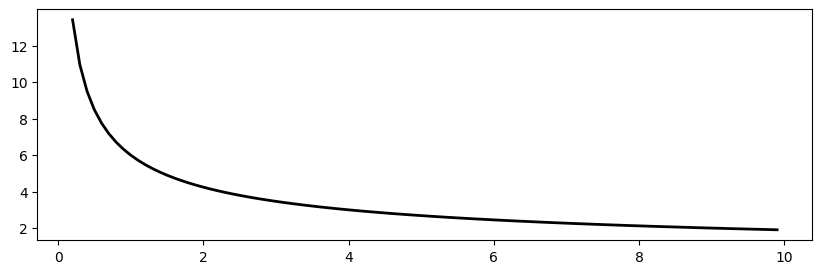

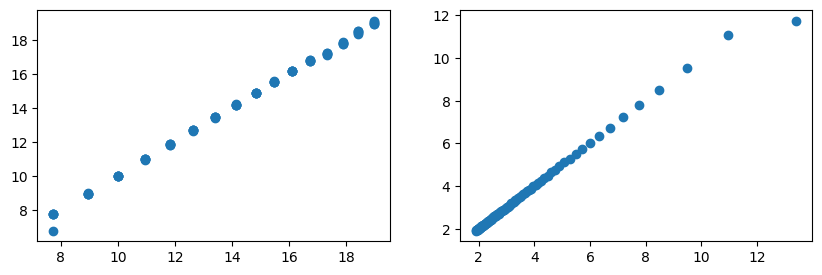

In [64]:
def taper_scale(window_sec, NW):
    M = int(round(window_sec * fs))
    K = int(np.floor(2*NW - 1))
    tapers = dpss(M, NW, Kmax=K, return_ratios=False)
    tapers = np.asarray(tapers)
    if tapers.shape[0] == M: tapers = tapers.T
    tapers /= np.linalg.norm(tapers, axis=1, keepdims=True)
    sum_w = np.sum(tapers, axis=1)[2]
    return 2*np.sqrt(K)/np.sqrt(window_sec)

window_sec = 0.2
NW_ranges = np.arange(2, 10, 0.1)
plt.figure(figsize=(10, 3))
taper_scales_range_NW = np.empty_like(NW_ranges)
for i, NW in enumerate(NW_ranges):
    taper_scales_range_NW[i] = taper_scale(window_sec, NW)
plt.plot(NW_ranges, taper_scales_range_NW, 'k-', lw=2)


NW = 5
window_sec_ranges = np.arange(0.2, 10, 0.1)
plt.figure(figsize=(10, 3))
taper_scales_range_window_sec = np.empty_like(window_sec_ranges)
for i, window_sec in enumerate(window_sec_ranges):
    taper_scales_range_window_sec[i] = taper_scale(window_sec, NW)
plt.plot(window_sec_ranges, taper_scales_range_window_sec, 'k-', lw=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(taper_scales_range_NW, scales_range_NW)
ax[1].scatter(taper_scales_range_window_sec, scales_range_window_sec)


In [10]:
import numpy as np
import spynal.spectra as spy_spec

# cache κ(fs) so you calibrate once per sampling rate
_SPYNAL_KAPPA = {}

def _spynal_band_rms(signal, fs, f0, window_sec, NW, removeDC=False, pad=False):
    """Your original pipeline: Spynal MT -> taper-avg -> derotate -> band RMS (NO extra scaling)."""
    W = NW / window_sec
    n_tapers = int(np.floor(2*NW - 1))
    print("n_tapers", n_tapers)
    S_raw, freqs, t_cent = spy_spec.spectrogram(
        data=signal[None,:], smp_rate=fs, axis=1,
        method='multitaper', spec_type='complex',
        removeDC=removeDC, keep_tapers=True,
        time_width=window_sec, spacing=window_sec,
        freq_width=4, n_tapers=n_tapers, pad=pad,
    )
    S = S_raw[0]                                   # (F,K,T)
    # derotate to window center (phase only; magnitude unchanged)
    rot = np.exp(1j*2*np.pi*freqs[:,None]*(t_cent[None,:]-window_sec/2))
    S = S * rot[ :, None, : ]                      # (F,K,T)
    # taper-avg -> (F,T)
    C_fT = S.mean(axis=1)
    # select band and RMS across bins
    band = (freqs >= f0-W) & (freqs <= f0+W)
    A_band = np.sqrt(np.sum(np.abs(C_fT[band])**2, axis=0))   # (T,)
    return A_band, t_cent, freqs

def _kappa_spynal(fs, *, window_ref=0.5, NW_ref=3.0, f_ref=30.0):
    """Compute κ(fs) once at a convenient reference (T*, NW*)."""
    key = (float(fs),)
    if key in _SPYNAL_KAPPA:
        return _SPYNAL_KAPPA[key]
    M = int(round(window_ref * fs))
    t = np.arange(4*M) / fs
    tone = np.cos(2*np.pi*f_ref*t)                 # 1 V pure tone at a grid bin
    A_raw, _, _ = _spynal_band_rms(tone, fs, f_ref, window_ref, NW_ref, removeDC=False, pad=False)
    mean_raw = float(np.mean(A_raw))
    kappa = (1.0 / mean_raw) 
    _SPYNAL_KAPPA[key] = kappa
    return kappa

def spynal_band_envelope_corrected(signal, fs, f0, *, window_sec=0.3, NW=2.0, removeDC=False, pad=False):
    """Your band envelope with principled, parameter-only scaling that preserves correlation."""
    A_raw, t_cent, freqs = _spynal_band_rms(signal, fs, f0, window_sec, NW, removeDC, pad)
    kappa = _kappa_spynal(fs, window_ref=window_sec, NW_ref=NW, f_ref=f0)                      # once per fs       # parameter-only global gain
    A_corr = A_raw * kappa
    return A_corr, t_cent, freqs, kappa

# simulate lfp, A_true ... (as in your snippet)

A_corr, t_spy, freqs_spy,  kappa = spynal_band_envelope_corrected(
    lfp, fs, f0=f0, window_sec=0.3, NW=1, removeDC=False, pad=False
)
A_true_cent = np.interp(t_spy, np.arange(len(A_true))/fs, A_true)

err = A_corr - A_true_cent
rmse = float(np.sqrt(np.mean(err**2)))
bias = float(np.mean(err))
r    = float(np.corrcoef(A_corr, A_true_cent)[0,1])
print(f"scale = κ(fs)*sqrt(NW/T)  with κ(fs)={kappa:.6g}")
print(f"RMSE={rmse:.4f}, Bias={bias:.4f}, r={r:.4f}")


n_tapers 1
n_tapers 1
scale = κ(fs)*sqrt(NW/T)  with κ(fs)=3.65664
RMSE=0.1516, Bias=-0.1020, r=0.9375
